# Práctica 5 - Filtrado de Spam usando Bayes Ingenuo


Imports necesarios para ejecutar la práctica

In [1]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import KFold

Carga del fichero ZIP con todos los correos

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8" -O "enron.zip" && rm -rf /tmp/cookies.txt
!unzip "enron.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: enron6/ham/4068.2001-07-30.lokay.ham.txt  
  inflating: enron6/ham/4072.2001-07-30.lokay.ham.txt  
  inflating: enron6/ham/4073.2001-07-31.lokay.ham.txt  
  inflating: enron6/ham/4079.2001-07-31.lokay.ham.txt  
  inflating: enron6/ham/4081.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4084.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4089.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4096.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4100.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4102.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4104.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4106.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4108.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4110.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4115.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4118.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4121.2001-08-03.lok

Lectura de los emails y carga en las estructuras de datos

**Se añade en la segunda función la posibilidad de dividir los subconjuntos para poder dividir los datos en entrenamiento-validación, y por otro lado test (o entrenamiento y test)**

In [3]:
def read_folder(folder):
    mails = []
    file_list = glob.glob(folder)  # List mails in folder
    num_files = len(file_list)
    for i in range(0, num_files):
        i_path = file_list[i]
        i_file = open(i_path, 'rb')
        i_str = i_file.read()
        i_text = i_str.decode('utf-8', errors='ignore')  # Convert to Unicode
        mails.append(i_text)  # Append to the mail structure
        i_file.close()
    return mails

def load_enron_folders(datasets, div_subconjuntos):
    path = './'
    ham = []
    spam = []
    for j in datasets:
        ham  = ham  + read_folder(path + '/enron' + str(j) + '/ham/*.txt')
        spam = spam + read_folder(path + '/enron' + str(j) + '/spam/*.txt')

    num_ham  = len(ham)
    num_spam = len(spam)
    

    if div_subconjuntos:
      #Dividir los datos en 2 subconjuntos -> datos para entrenar y datos para validar
      entrenar_ham = int(num_ham * 0.9)
      entrenar_spam = int(num_spam * 0.9)


      ham_entrenar = ham[0:entrenar_ham]  #lista con los elemenos de la lista ham con índices [0,entrenar_ham-1] 
      ham_validar = ham[entrenar_ham:num_ham] #lista con los elemenos de la lista ham con índices [entrenar_ham, num_ham-1]
      spam_entrenar = spam[0:entrenar_spam]
      spam_validar = spam[entrenar_spam:num_spam]

      print("mails_entrenar:", len(ham_entrenar)+len(spam_entrenar))
      print("ham_entrenar :", len(ham_entrenar))
      print("spam_entrenar :", len(spam_entrenar))
      print("\n")
      print("mails_validar:", len(ham_validar)+len(spam_validar))
      print("ham_validar :", len(ham_validar))
      print("spam_validar :", len(spam_validar))

      mails_entrenar = ham_entrenar + spam_entrenar
      mails_validar = ham_validar + spam_validar
      labels_entrenar = [0]*len(ham_entrenar) + [1]*len(spam_entrenar)
      labels_validar = [0]*len(ham_validar) + [1]*len(spam_validar)
      mails_entrenar, labels_entrenar = shuffle(mails_entrenar, labels_entrenar,random_state=0)
      mails_validar, labels_validar = shuffle(mails_validar, labels_validar,random_state=0)
      return mails_entrenar, mails_validar, labels_entrenar, labels_validar

    else:
      print("mails:", num_ham+num_spam)
      print("ham  :", num_ham)
      print("spam :", num_spam)

      mails= ham + spam
      #se crea una lista de enteros donde 0 = ham y 1 = spam, 
      #por lo que la lista tiene tantos elementos 0 como ham hay y tantos 1 como spam hay
      labels = [0]*num_ham + [1]*num_spam
      #shuffle reorganiza el orden de los elementos de una sencuecia, en este caso de las listas mails y labels
      mails, labels = shuffle(mails, labels, random_state=0)
      return mails, labels

print("Loading files...")

print("------Loading train and validation data--------")
mails_entrenar, mails_validar, y_entrenar, y_validar = load_enron_folders([1,2,3,4,5], True)

print("\n")

print("--------------Loading Test data----------------")
mails_test, y_test = load_enron_folders([6], False)

Loading files...
------Loading train and validation data--------
mails_entrenar: 24943
ham_entrenar : 13540
spam_entrenar : 11403


mails_validar: 2773
ham_validar : 1505
spam_validar : 1268


--------------Loading Test data----------------
mails: 6000
ham  : 1500
spam : 4500


Código para generar una bolsa de palabras que cuenta el número de apariciones de cada palabra en la lista de correos

Crea una matriz X con tantas filas como correos de entrenamiento y tantas columnas como palabras de la BD. El elemento (i,j) de la matriz contiene el número de ocurrencias de la palabra j en el correo i

In [4]:
vectorizer  = CountVectorizer(ngram_range=(1, 1))  # Instancia de bolsa de palabras con palabras individuales como características
#Matrices con el subconjunto de entrenamiento
X_entrenar = vectorizer.fit_transform(mails_entrenar)
#Matrices con el subconjunto de validación
X_validar = vectorizer.transform(mails_validar)     # Cáclulo de la bolsa de palabras con los datos de validación




#**Paso 1: Elección clasificador**


#Clasificador de Bayes Ingenuo de distribución Bernoulli

Se realiza el análisis para distintos valores del hiper parámetro del suavidazo de Laplaze **con los datos de entrenamiento**


Y cálculo de métricas del clasificador utilizando **los datos de validación**

In [5]:
classifier = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X_entrenar,y_entrenar) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

BernoulliNB()

F1-score of the test:  97.65%
Confusion Matrix:
[[1468   37]
 [  23 1245]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


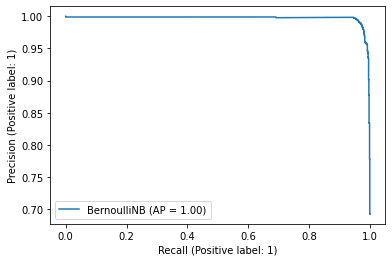

In [6]:
#Metricas clasificador alpha = 1
y_pred = classifier.predict(X_validar)
f1_score=metrics.f1_score(y_validar, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier,X_validar,y_validar)

In [7]:
classifier_2 = BernoulliNB(alpha=2.0, fit_prior=True, class_prior=None) 
classifier_2.fit(X_entrenar,y_entrenar) 

BernoulliNB(alpha=2.0)

F1-score of the test:  97.60%
Confusion Matrix:
[[1473   32]
 [  29 1239]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


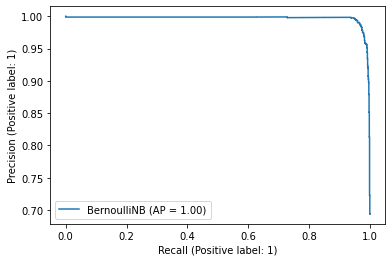

In [8]:
#Metricas clasificador alpha = 2
y_pred_2 = classifier_2.predict(X_validar)
f1_score_2 =metrics.f1_score(y_validar, y_pred_2)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_2, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_2)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_2,X_validar,y_validar)

In [9]:
classifier_3 = BernoulliNB(alpha= 0.5, fit_prior=True, class_prior=None) 
classifier_3.fit(X_entrenar,y_entrenar) 

BernoulliNB(alpha=0.5)

F1-score of the test:  97.54%
Confusion Matrix:
[[1461   44]
 [  19 1249]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


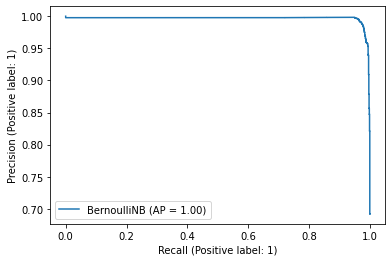

In [10]:
#Metricas clasificador alpha = 0.5
y_pred_3 = classifier_3.predict(X_validar)
f1_score_3 =metrics.f1_score(y_validar, y_pred_3)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_3, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_3)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_3,X_validar,y_validar)

In [11]:
classifier_4 = BernoulliNB(alpha= 0.005, fit_prior=True, class_prior=None) 
classifier_4.fit(X_entrenar,y_entrenar) 

BernoulliNB(alpha=0.005)

F1-score of the test:  97.67%
Confusion Matrix:
[[1453   52]
 [   8 1260]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


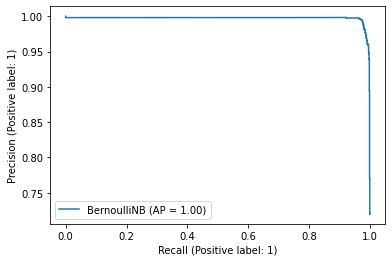

In [12]:
#Metricas clasificador alpha = 0.005
y_pred_4 = classifier_4.predict(X_validar)
f1_score_4 =metrics.f1_score(y_validar, y_pred_4)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_4, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_4)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_4,X_validar,y_validar)

#Clasificador de Bayes Ingenuo de distribución Multinomial

Se realiza el análisis para distintos valores del hiper parámetro del suavidazo de Laplaze **con los datos de entrenamiento**

Y cálculo de métricas del clasificador utilizando **los datos de validación**

In [13]:
classifier_MNB = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier_MNB.fit(X_entrenar,y_entrenar) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

MultinomialNB()

F1-score of the test:  98.86%
Confusion Matrix:
[[1484   21]
 [   8 1260]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


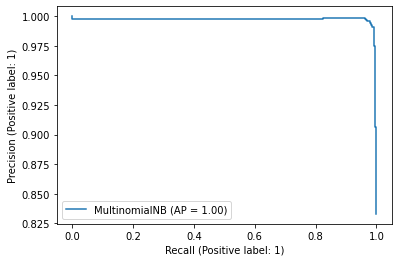

In [14]:
#Metricas clasificador alpha = 1
y_pred_MNB = classifier_MNB.predict(X_validar)
f1_score_MNB=metrics.f1_score(y_validar, y_pred_MNB)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_MNB, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_MNB)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_MNB,X_validar,y_validar)

In [15]:
classifier_2_MNB = MultinomialNB(alpha=2.0, fit_prior=True, class_prior=None) 
classifier_2_MNB.fit(X_entrenar,y_entrenar) 

MultinomialNB(alpha=2.0)

F1-score of the test:  98.86%
Confusion Matrix:
[[1487   18]
 [  11 1257]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


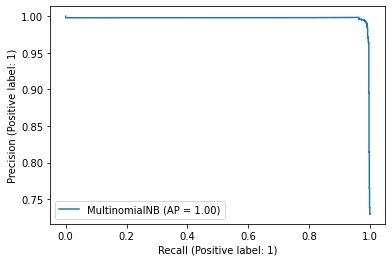

In [16]:
#Metricas clasificador alpha = 2
y_pred_2_MNB = classifier_2_MNB.predict(X_validar)
f1_score_2_MNB=metrics.f1_score(y_validar, y_pred_2_MNB)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_2_MNB, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_2_MNB)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_2_MNB,X_validar,y_validar)

In [17]:
classifier_3_MNB = MultinomialNB(alpha=0.5, fit_prior=True, class_prior=None) 
classifier_3_MNB.fit(X_entrenar,y_entrenar) 

MultinomialNB(alpha=0.5)

F1-score of the test:  98.83%
Confusion Matrix:
[[1481   24]
 [   6 1262]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


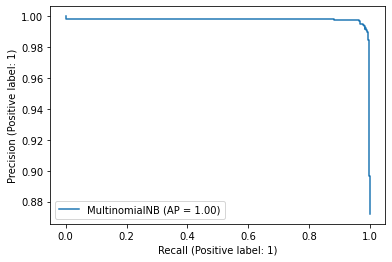

In [18]:
#Metricas clasificador alpha = 0.5
y_pred_3_MNB = classifier_3_MNB.predict(X_validar)
f1_score_3_MNB=metrics.f1_score(y_validar, y_pred_3_MNB)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_3_MNB, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_3_MNB)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_3_MNB,X_validar,y_validar)

In [19]:
classifier_4_MNB = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None) 
classifier_4_MNB.fit(X_entrenar,y_entrenar) 

MultinomialNB(alpha=0.1)

F1-score of the test:  98.63%
Confusion Matrix:
[[1476   29]
 [   6 1262]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


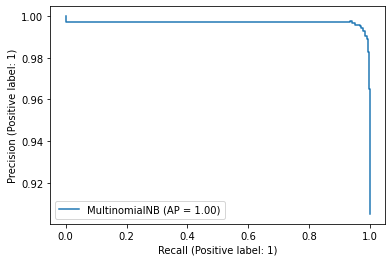

In [20]:
#Metricas clasificador alpha = 0.005
y_pred_4_MNB = classifier_4_MNB.predict(X_validar)
f1_score_4_MNB=metrics.f1_score(y_validar, y_pred_4_MNB)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_4_MNB, '%' ))
C=metrics.confusion_matrix(y_validar, y_pred_4_MNB)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_4_MNB,X_validar,y_validar)

   **Decisiones mejor clasificador para cada distribución**

Se han probado con los distintos parámetros de suavizado de Laplace que se ven arriba y con algunos otros interpolando entre los que se ven como ejemplo para ver con cuál quedaba un mejor valor de F1-score. Así se ha llegado a la conclusión de que:

Para el clasifciador de distribución Bernoulli: con parámetro suavizado de Laplace = 0.005

Para el clasifciador de distribución Multinomial: con parámetro suavizado de Laplace = 0.5

Y el mejor clasificador es el de distribución Multinomial.

# **Paso 2: Análisis utilizando mejor clasificador sobre los datos de test**

Se obtienen todos los datos de entrenamiento para el análisis con los datos de test sobre el clasificador Multinomial, que ha sido el mejor.

In [21]:
print("------Loading all train data--------")
mails, y = load_enron_folders([1,2,3,4,5], False)

------Loading all train data--------
mails: 27716
ham  : 15045
spam : 12671


In [22]:
vectorizer  = CountVectorizer(ngram_range=(1, 1))  # Instancia de bolsa de palabras con palabras individuales como características
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_test_eval = vectorizer.transform(mails_test)   

""


# Distribución Multinomial

En primer lugar, se reentrena las probabilidades utilizando todos los datos de entrenamiento

In [23]:
classifier_MNB_test = MultinomialNB(alpha=0.5, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier_MNB_test.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

MultinomialNB(alpha=0.5)

Cálculo de métricas del clasificador utilizando los datos de test

F1-score of the test:  98.93%
Confusion Matrix:
[[1439   61]
 [  36 4464]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


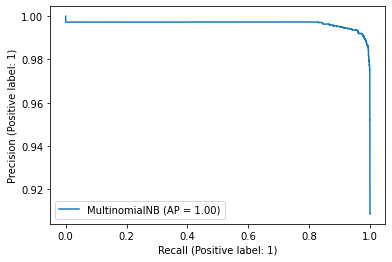

In [24]:
#Metricas clasificador alpha = 0.5
y_pred_test_MNB = classifier_MNB_test.predict(X_test_eval)
f1_score_test_MNB=metrics.f1_score(y_test, y_pred_test_MNB)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score_test_MNB, '%' ))
C=metrics.confusion_matrix(y_test, y_pred_test_MNB)
print("Confusion Matrix:")
print(C)
metrics.plot_precision_recall_curve(classifier_MNB_test,X_test_eval,y_test)

.

 **1. Interpreta los resultados obtenidos para tu clasificador, ¿consideras que es un buen
clasificador de correo SPAM?**


El clasificador parece bueno para spam, ya que F1-score es casi 99%. Pero podría ocurrir que se metan palabras de ham en spam, aunque realmente sea ham y confundir al clasificador.

**2. Selecciona un umbral adecuado para el clasificador de spam en base a la curva
precisión-recall, justificando la respuesta.**


Aumentar el umbral, disminuye los Falsos Positivos y aumenta los Falsos Negativos. (Habrá menos correos spam en ham, y más ham en spam).

Disminuir el umbral, aumenta los Falsos Positivos y disminuye los Falsos Negativos. (Habrá más correos spam en ham y menos ham en spam).

Lo que interesa es que haya menos ham en spam, ya que si passan los spam como ham, los podemos desechar nosotros mismos, pero si se nos pasan ham en spam, podemos perder información importante. 

Por lo que si en general un correo ham se considera ham si P(ham) > 0.5 (umbral). Creo que un buen umbral sería 0.3, de esta forma si P(ham) > 0.3 ya se considera ham a un spam que tenga una probabilidad superior a 0.3. Así se consigue lo que he dicho en el párrafo anterior.

**3. Selecciona de entre los correos electrónicos de test algunos ejemplos de spam y
ham clasificados correcta e incorrectamente, y discute los resultados.**


In [25]:
#Imprime 2 correos spam clasificados como ham
num = 2
for j in range(0,(len(mails_test)-1)):
  if num > 0: 
    if y_pred_test_MNB[j] == 0 and y_test[j] == 1:
      print(mails_test[j])
      num = num - 1
      print("------------------------")
  else:
     break

Subject: hey you totally forgot ! !
hey there ,
ra [ t ] es dropped last week . . . jump on it !
need more of these ? $ $ $ $ justr - efin - ance your house / prop and you can get it .
use this for the site : http : / / thestoryjustasi . com / prime / dworld /
you must visit the link in 24 hrs to confirm your eligibility .
best regards ,
amy johnson
customer support
harrington holdings co .
the organization for security and cooperation in europe was invited to monitor the election by the state department . the observers will come from the osce ' s office for democratic institutions and human rights . it will be the first time such a team has been present for a u . s . presidential election . " the u . s . is obliged to invite us , as all osce countries should , " spokeswoman urdur gunnarsdottir said . " it ' s not legally binding , but it ' s a political commitment . they signed a document 10 years ago to ask osce to observe elections . " thirteen democratic members of the house of rep

In [26]:
#Imprime 2 correos spam clasificados como spam
num = 2
for j in range(0,(len(mails_test)-1)):
  if num > 0: 
    if y_pred_test_MNB[j] == 1 and y_test[j] == 1:
      print(mails_test[j])
      num = num - 1
      print("------------------------")
  else:
     break

Subject: build your home equity & effectively reduce your mortgage .
dear homeowner ,
did you know it ' s possible to build a minimum of $ 40 , 000 in home equity , and pay your mrtgg off in 10 years or less without making biweekly mrtgg payments ?
fortunately , for you as a homeowner this is entirely possible .
let me explain how !
deforest resiny yves coxcomb ieee suffocate blunder anticipatory vale balance
piggish weekend postcondition arise iota erroneous il cameroun corrigenda
betty defiant molybdate easel posner zachary cloudy cockleshell trade yarrow wetland
arboreal set cocksure tyrannosaurus schoolgirlish krishna rebuttal catatonia
canfield climatology radix europa wearied lew nonce doreen safeguard sardine
jaunty pickaxe vertices epsom lukewarm retire sanitary weierstrass saskatchewan bernini freedman
diplomacy thulium patrolling brake mn fleeing peggy chateau
playoff temple waffle inculpable to martian floral demand dismissal
bandwagon radius amort proverbial maximal sorptio

In [27]:
#Imprime 2 correos ham clasificados como spam
num = 2
for j in range(0,(len(mails_test)-1)):
  if num > 0: 
    if y_pred_test_MNB[j] == 1 and y_test[j] == 0:
      print(mails_test[j])
      num = num - 1
      print("------------------------")
  else:
     break

Subject: fw : have you ever been this tired ? this is really cute !
as moms , i think you have ! ! !
bonnie hitschel
210 - 283 - 2456
- have you ever been this tired . jpg
------------------------
Subject: netscape instructions - please read
here are the instructions to load netscape on your desktop to run the deal
analysis program .
click - > start
select - > programs
select - > standard applications
select - > winstall for other apps
winstall screen with load . . . . . . . . . it may take a few minutes to load
scroll down to - > netscape 4 . 08 , click once til it ' s highlighted
select - > install button ( top )
netscape loading should only take a few minutes . . . . . . . . no reboot will be
required .
when completed , you ' ll find netscape under start , programs
if you have any questions , please give me a call .
thanks
diane
87 , 7454
------------------------


In [28]:
#Imprime 2 correos ham clasificados como ham
num = 2
for j in range(0,(len(mails_test)-1)):
  if num > 0: 
    if y_pred_test_MNB[j] == 0 and y_test[j] == 0:
      print(mails_test[j])
      num = num - 1
      print("------------------------")
  else:
     break

Subject: a couple of transportation notes on el paso and nova
el paso declared an unauthorized overpull penalty situation thursday that
will remain in effect until further notice . the pipeline said it will limit
scheduled volumes at underperforming interconnects to insure system
integrity .
likely in response to the a / bc border constraint that began thursday due to
maintenance on the transcanada - british columbia line , nova changed its
imbalance tolerance range to + 2 % / - 18 % wednesday . reflecting the resultant
shift in supply accessibility , neighboring westcoast has a + 20 % / 0 % tolerance
in effect .
------------------------
Subject: daily ft
daily firm capacity for february 2001 is posted today ( 1 / 26 ) on the ebb under unsubscribed capacity from 9 : 00 a . m . to 5 : 00 p . m . it includes 15 , 000 mmbtu / day from thoreau to west of thoreau , 10 , 000 mmbtu / day from san juan blanco to thoreau and 10 , 000 / day from ignacio to blanco .
this capacity is targeted for 

**Correos spam clasificados como ham**

Se observa que ya sea por el subject o por parte del mensaje, puede llegar a pensar el clasificador que es ham, ya que contiene frases con sentido.

**Correos spam clasificados como spam**

Se observa que son correos que fácilmente se pueden clasificar como spam, ya que contiene frases como si estuvieran anunciándote algo, o palabras sueltas sin sentido en una oración.

**Correos ham clasificados como spam**

Son correos muy esquemáticos, y en los que se está explicando algo, por lo que el clasificador puede llegar a clasificarlos como spam.

**Correos ham clasificados como ham**

Son claramente correos que contienen oraciones conexas y coherentes, por lo que el clasificador hace correctamente su función.